In [186]:
import pandas as pd
import spotipy
import spotipy.util as util
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm_notebook
from google.cloud import language_v1
from google.cloud.language_v1 import enums
import six
import os

In [58]:
key_file = 'assets/keys.json'
keys = json.load(open(key_file))

SPOTIPY_CLIENT_ID= keys["client_id"]
SPOTIPY_CLIENT_SECRET= keys["client_secret"]
SPOTIPY_REDIRECT_URI= keys["redirect_url"]

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/carlosortega/Documents/GitHub/SUSA-Research-MusicMoods/assets/google_keys.json"

In [59]:
token = util.prompt_for_user_token("1274418332", 
                                   scope = "user-library-read", 
                                   client_id=SPOTIPY_CLIENT_ID, 
                                   client_secret=SPOTIPY_CLIENT_SECRET, 
                                   redirect_uri = SPOTIPY_REDIRECT_URI)
spotify = spotipy.Spotify(auth=token)

In [60]:
billboard = pd.read_csv("data/billboard_lyrics_1964-2015.csv")
billboard['Query'] = 'artist: ' + billboard['Artist'] + ', track: ' + billboard['Song']
billboard.head()

,Rank,Song,Artist,Year,Lyrics,Source,Query
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0,"artist: sam the sham and the pharaohs, track: ..."
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0,"artist: four tops, track: i cant help myself s..."
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0,"artist: the rolling stones, track: i cant get ..."
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0,"artist: we five, track: you were on my mind"
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0,"artist: the righteous brothers, track: youve l..."


In [ ]:
song_id = spotify.search("artist: kesha, track: tik tok")['tracks']['items'][0]['id']
valence = spotify.audio_features(song_id)[0]['valence']
valence

In [62]:
valences = []
durations = []
for index, row in tqmd_notebook(billboard.iterrows()):
    try:
        curr_song = spotify.search(row['Query'])['tracks']['items'][0]['id']
        valence = spotify.audio_features(curr_song)[0]['valence']
        duration = spotify.audio_features(curr_song)[0]['duration_ms']
        durations.append(duration)
        valences.append(float(valence))
    except:
        valences.append(np.nan)
        valences.append(np.nan)

billboard['Valence'] = valences
billboard['Duration_ms'] = durations

In [63]:
billboard.to_csv("data/billboard_with_data.csv", index=False)
billboard.head()

In [126]:
billboard_updated = pd.read_csv("data/billboard_with_data.csv")
billboard_updated['Lyrics'].replace('  ', np.nan, inplace=True)
billboard_updated.dropna(axis=0,inplace=True)
billboard_updated.drop('Source', axis = 1, inplace=True)
billboard_updated.head()

,Rank,Song,Artist,Year,Lyrics,Query,Valence,Sentiment,Duration
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,"artist: sam the sham and the pharaohs, track: ...",0.558,-0.9,140867
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,"artist: four tops, track: i cant help myself s...",0.964,-0.9,163680
2,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,"artist: we five, track: you were on my mind",0.7,0.6,155960
3,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,"artist: the righteous brothers, track: youve l...",0.376,-0.2,226453
4,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,"artist: petula clark, track: downtown",0.545,0.7,183120


In [66]:
def authenticate():
    from google.cloud import storage

    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())

authenticate()

[]


In [ ]:
lyrics = []
for index, row in tqdm_notebook(billboard_updated.iterrows()):
    lyric = row['Lyrics']
    if isinstance(lyric, six.binary_type):
        lyric = lyric.decode('utf-8')
    lyrics.append(lyric)

In [ ]:
client = language_v1.LanguageServiceClient()

type_ = enums.Document.Type.PLAIN_TEXT

sentiments = []
for i in tqdm_notebook(range(len(lyrics))):
    document = {'type': type_, 'content': lyrics[i]}
    
    try:
        response = client.analyze_sentiment(document)
    except:
        sentiments.append(np.nan)
        continue
    
    sentiment = response.document_sentiment
    
    sentiments.append(sentiment.score)

billboard_updated['Sentiment'] = sentiments
billboard_updated.dropna(axis=0,inplace=True)
billboard_updated.to_csv("data/billboard_with_data.csv", index=False)

In [77]:
billboard_updated = pd.read_csv("data/billboard_with_data.csv")
billboard_updated.head()

,Rank,Song,Artist,Year,Lyrics,Query,Valence,Sentiment,Duration
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,"artist: sam the sham and the pharaohs, track: ...",0.558,-0.9,140867
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,"artist: four tops, track: i cant help myself s...",0.964,-0.9,163680
2,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,"artist: we five, track: you were on my mind",0.7,0.6,155960
3,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,"artist: the righteous brothers, track: youve l...",0.376,-0.2,226453
4,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,"artist: petula clark, track: downtown",0.545,0.7,183120


In [ ]:
(1 - ((1 - valence) + (pct_sad * (1 + lyrical_density))) / 2, to = c(1, 100))

In [158]:
#New Table with Only Necessary Info
stats = billboard_updated[['Year', 'Valence', 'Sentiment', 'Duration_ms']]
# stats['Duration_s'] = billboard_updated['Duration_ms'] / 1000
stats['Word Count'] = billboard_updated['Lyrics'].apply(len) 
stats['Lyrical Density'] = stats['Word Count'] / stats['Duration_ms'] * 1000
stats.head()

/Users/carlosortega/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/carlosortega/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Year,Valence,Sentiment,Duration_ms,Word Count,Lyrical Density
0,1965,0.558,-0.9,140867.0,662,4.699468
1,1965,0.964,-0.9,163680.0,995,6.078935
2,1965,0.700,0.6,155960.0,692,4.437035
3,1965,0.376,-0.2,226453.0,1173,5.179883
4,1965,0.545,0.7,183120.0,1333,7.279380


In [160]:
gloom_index = ((1 - stats['Valence']) + (stats['Sentiment'] * (1 + stats['Lyrical Density']))) / 2
stats['Gloom Index'] = gloom_index
stats.head()

/Users/carlosortega/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Year,Valence,Sentiment,Duration_ms,Word Count,Lyrical Density,Gloom Index
0,1965,0.558,-0.9,140867.0,662,4.699468,-2.343761
1,1965,0.964,-0.9,163680.0,995,6.078935,-3.167520
2,1965,0.700,0.6,155960.0,692,4.437035,1.781111
3,1965,0.376,-0.2,226453.0,1173,5.179883,-0.305988
4,1965,0.545,0.7,183120.0,1333,7.279380,3.125283


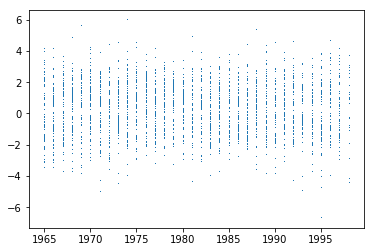

In [197]:
gloom_by_year = stats[['Year', 'Gloom Index']]
plt.plot(gloom_by_year['Year'], gloom_by_year['Gloom Index'], ',')
plt.show()

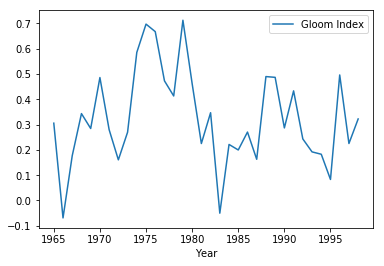

In [195]:
means = gloom_by_year.groupby(by="Year").mean()
means.plot()
plt.show()
